In [45]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, Bidirectional, GlobalMaxPool1D
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from collections import Counter
from joblib import dump

%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
nlp = spacy.load('en')

In [3]:
def clear(df):
    for i in tqdm(range(df.shape[0])):
        doc = nlp(df['headline'][i])
        text = [w.lemma_.lower().strip() for w in doc 
               if not (w.is_stop |
                    w.is_punct |
                    w.is_digit)
               ]
        text = " ".join(text)

        df['headline'][i] = text

    return df

In [4]:
df = pd.read_csv('data_clear.csv')
df = df[['headline', 'is_sarcastic']].dropna()

In [5]:
df.head()

,headline,is_sarcastic
0,versace store clerk sue secret black code mino...,0
1,roseanne revival catch thorny political mood bad,0
2,mom start fear son web series close thing gran...,1
3,boehner want wife listen come alternative debt...,1
4,j.k rowle wish snape happy birthday magical way,0


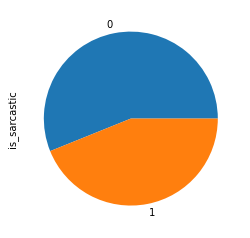

In [6]:
df['is_sarcastic'].value_counts().plot('pie')

In [7]:
words_sar = dict(Counter([word for headline in df['headline'][df['is_sarcastic'] == 1] for word in str(headline).split()]).most_common(50))
words_acc = dict(Counter([word for headline in df['headline'][df['is_sarcastic'] == 0] for word in str(headline).split()]).most_common(50))

In [8]:
wordcloud = WordCloud(background_color='black', width=1000,height=700)
wordcloud.generate_from_frequencies(frequencies=words_sar)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
wordcloud = WordCloud(background_color='black', width=1000,height=700)
wordcloud.generate_from_frequencies(frequencies=words_acc)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Classification

## Naive Bayes


In [17]:
X = df['headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
model_nb = Pipeline([('tf', TfidfVectorizer()),
                     ('nb', BernoulliNB())])
model_nb.fit(X_train, y_train)

In [ ]:
pred = model_nb.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
params_nb = {'tf__ngram_range': [(1, 2), (1, 3)],
              'nb__alpha': (1, 1e-2, 1e-3, 0),
}

gs_nb = GridSearchCV(model_nb, params_nb, n_jobs=-1, cv=5, scoring="accuracy")
gs_nb.fit(X, y)

In [ ]:
gs_nb.best_score_

## Support Vector Machine

In [ ]:
model_svc = Pipeline([('tf', TfidfVectorizer(ngram_range=(1, 2))),
                      ('svc', LinearSVC(dual=False))])
model_svc.fit(X_train, y_train)

In [ ]:
pred = model_svc.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
params_svc = {'tf__ngram_range': [(1, 2), (1, 3)],
              'svc__C': (1, 1e2, 1e3, 1e4, 1e5),
}

gs_svc = GridSearchCV(model_svc, params_svc, n_jobs=-1, cv=5, scoring="accuracy")
gs_svc.fit(X, y)

In [ ]:
gs_svc.best_params_

In [ ]:
def predict(text):
    res = model_svc.predict([text])[0]
    return "Sarcastic" if res else "Acclaim"

In [ ]:
predict("‘Game Of Thrones’ Fans Annoyed By Obvious Product Placement For Valyrian Steel")

## LSTM

In [48]:
max_features = 10000
max_len = 35
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [49]:
model = Sequential()
model.add(Embedding(max_features, 200, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(sequences_matrix, y_train, batch_size=100, epochs=5,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Train on 14955 samples, validate on 3739 samples
Epoch 1/5
14955/14955 [==============================] - 118s 8ms/step - loss: 0.6419 - acc: 0.6353 - val_loss: 0.5208 - val_acc: 0.7620
Epoch 2/5
14955/14955 [==============================] - 83s 6ms/step - loss: 0.4563 - acc: 0.8073 - val_loss: 0.4628 - val_acc: 0.7879
Epoch 3/5
14955/14955 [==============================] - 95s 6ms/step - loss: 0.3632 - acc: 0.8620 - val_loss: 0.4546 - val_acc: 0.7834
Epoch 4/5
14955/14955 [==============================] - 81s 5ms/step - loss: 0.3029 - acc: 0.8893 - val_loss: 0.4970 - val_acc: 0.7868


In [51]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
score = model.evaluate(test_sequences_matrix, y_test, batch_size=16)

5392/8012 [===================>..........] - ETA: 20s

In [ ]:
print('Loss: {:0.3f}'.format(score[0]))
print('Accuracy: {:0.3f}'.format(score[1]))

In [50]:
model.save('model_lstm.h5')